### Hybrid CNN-LSTM Model combines:
- CNN (Convolutional Neural Network): Extracts spatial patterns from time-series sensor data.
- LSTM (Long Short-Term Memory): Captures temporal dependencies for movement analysis.
- Model is used to predict task ttype

In [305]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, Input, Model, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras # used to build CNN

In [306]:
# Load extracted features
df = pd.read_csv("../processed-data/cleaned-parkinsons-data.csv")

#### Scale Features

In [ ]:

# define and scale sensor columns
sensor_columns = ["Accel_X", "Accel_Y", "Accel_Z", "Gyro_X", "Gyro_Y", "Gyro_Z"]
# apply MinMaxScaler (-1 to 1) to sensor data
scaler_sensor = MinMaxScaler(feature_range=(-1, 1))
df[sensor_columns] = scaler_sensor.fit_transform(df[sensor_columns])

# define and scale demographic columns
demographic_col = ["Age_At_Diagnosis", "Height", "Weight", "Gender", "Handedness"]
# apply standard scaler to demographic data
scaler_demographic = StandardScaler()
df[demographic_col] = scaler_demographic.fit_transform(df[demographic_col])

# gather input features and target
df = df[["Patient_id", "Task", "Device_Location"] + sensor_columns + demographic_col + ["Normalized_Time", "Condition"]]



#### Split data into training and testing sets 
- Ensure strict splitting to prevent data leakage and maintin sequence
- No patient data should appear in both train and test data

In [308]:
# split data into training and testing
# Get unique patients sorted (ensuring order is preserved)
unique_patients = sorted(df["Patient_id"].unique())  # Sorting ensures consistency

# Manually split: First 80% for training, last 20% for testing
split_idx = round(int(len(unique_patients) * 0.8))
train_patients = unique_patients[:split_idx]  # First 80% patients
test_patients = unique_patients[split_idx:]  # Last 20% patients

# Assign data to train and test sets
df_train = df[df["Patient_id"].isin(train_patients)].copy()
df_test = df[df["Patient_id"].isin(test_patients)].copy()

In [309]:
# Verify strict separation (no overlap)
assert set(df_train["Patient_id"]).isdisjoint(set(df_test["Patient_id"])), "Patient IDs overlap!"

In [310]:
# Ensure each dataset is sorted by Patient, Task, and Normalized Time
df_train = df_train.sort_values(by=["Patient_id", "Task", "Normalized_Time"])
df_test = df_test.sort_values(by=["Patient_id", "Task", "Normalized_Time"])

#### Segment Time-Series Data for Dual-Input by device location (left and right wrist)

In [311]:
# Time steps per sequence
window_size = 50  
step_size = 10    # Step size for sliding window

In [312]:
# define function to segment time series data
def segment_time_series_dual(df, window_size, step_size):
    """
    Segments the dataset into overlapping windows for CNN-LSTM training.
    Returns separate X_left, X_right, and y arrays.
    """
    X_left, X_right, y = [], [], []
    unique_patients = df["Patient_id"].unique()

    for patient in unique_patients:
        patient_df = df[df["Patient_id"] == patient].copy()

        # Select left and right wrist data
        left_df = patient_df[patient_df["Device_Location"] == "LeftWrist"]
        right_df = patient_df[patient_df["Device_Location"] == "RightWrist"]

        if len(left_df) == 0 or len(right_df) == 0:
            continue  # Skip if missing wrist data for this patient

        left_features = left_df[sensor_columns + demographic_col + ["Normalized_Time"]].values
        right_features = right_df[sensor_columns + demographic_col + ["Normalized_Time"]].values
        labels = left_df["Condition"].values  # Use left wrist labels

        # Create overlapping windows
        for i in range(0, min(len(left_features), len(right_features)) - window_size, step_size):
            X_left.append(left_features[i:i+window_size])
            X_right.append(right_features[i:i+window_size])
            y.append(labels[i + window_size - 1])  # Assign label from last time step

    return np.array(X_left), np.array(X_right), np.array(y)

In [313]:
# Segment data into sequences
X_train_left, X_train_right, y_train = segment_time_series_dual(df_train, window_size, step_size)
X_test_left, X_test_right, y_test = segment_time_series_dual(df_test, window_size, step_size)

# print the shape of the data
# Ensure both X_train_left and X_train_right have the same shape
print("X_train_left shape:", X_train_left.shape)
print("X_train_right shape:", X_train_right.shape)
print("y_train shape:", y_train.shape)

assert X_train_left.shape == X_train_right.shape, "❌ Left & Right input shapes do not match!"
assert X_test_left.shape == X_test_right.shape, "❌ Left & Right test shapes do not match!"
# save the split data


X_train_left shape: (3926, 50, 12)
X_train_right shape: (3926, 50, 12)
y_train shape: (3926,)


#### Build Dual-Branch CNN-LSTM Model

In [315]:
def build_dual_cnn_lstm_model(input_shape):
    left_input = Input(shape=input_shape, name="Left_Wrist_Input")
    right_input = Input(shape=input_shape, name="Right_Wrist_Input")

    # CNN-LSTM for Left Wrist
    left_branch = layers.Conv1D(32, kernel_size=3, activation='relu',
                                kernel_regularizer=regularizers.l2(0.001))(left_input)
    left_branch = layers.MaxPooling1D(pool_size=2)(left_branch)
    left_branch = layers.Dropout(0.5)(left_branch)
    left_branch = layers.LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(left_branch)
    left_branch = layers.LSTM(16, dropout=0.5, recurrent_dropout=0.2)(left_branch)

    # CNN-LSTM for Right Wrist
    right_branch = layers.Conv1D(32, kernel_size=3, activation='relu',
                                 kernel_regularizer=regularizers.l2(0.001))(right_input)
    right_branch = layers.MaxPooling1D(pool_size=2)(right_branch)
    right_branch = layers.Dropout(0.5)(right_branch)
    right_branch = layers.LSTM(32, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(right_branch)
    right_branch = layers.LSTM(16, dropout=0.5, recurrent_dropout=0.2)(right_branch)

    # Merge both branches
    merged = layers.Concatenate()([left_branch, right_branch])
    merged = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
    merged = layers.Dropout(0.5)(merged)
    output = layers.Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[left_input, right_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])
    
    return model

In [316]:

# Define input shape
input_shape = (50, X_train_left.shape[-1])  # 50 time steps, feature count from X_train_left

# Build and compile model
model = build_dual_cnn_lstm_model(input_shape)

### Compute class weight
- Address class imbalance

In [318]:
# Combine left and right wrist features for oversampling
num_samples, time_steps, num_features = X_train_left.shape

# Flatten time-series data for oversampling (Convert to 2D: (samples, time_steps * features))
X_train_left_flat = X_train_left.reshape(num_samples, -1)  # Shape: (samples, time_steps * features)
X_train_right_flat = X_train_right.reshape(num_samples, -1)  # Shape: (samples, time_steps * features)

# Stack Left & Right wrist data horizontally
X_train_combined = np.hstack((X_train_left_flat, X_train_right_flat))  # Shape: (samples, features_combined)

# Apply Oversampling on 2D data
ros = RandomOverSampler(random_state=42)
X_train_balanced_flat, y_train_balanced = ros.fit_resample(X_train_combined, y_train)

# Reshape back into 3D format (samples, time_steps, features)
split_index = num_features * time_steps  # Number of original left wrist features
X_train_left_balanced = X_train_balanced_flat[:, :split_index].reshape(-1, time_steps, num_features)
X_train_right_balanced = X_train_balanced_flat[:, split_index:].reshape(-1, time_steps, num_features)


# Print new class distribution
unique, counts = np.unique(y_train_balanced, return_counts=True)
print("Class distribution after oversampling:", dict(zip(unique, counts)))


Class distribution after oversampling: {0: 3110, 1: 3110}


In [319]:

history = model.fit(
    [X_train_left_balanced, X_train_right_balanced], y_train_balanced,
    epochs=50, batch_size=32,
    validation_data=([X_test_left, X_test_right], y_test)  # Test set remains untouched

)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Left_Wrist_Input', 'Right_Wrist_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5519 - loss: 0.7472 - val_accuracy: 0.6290 - val_loss: 0.7245
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6766 - loss: 0.6879 - val_accuracy: 0.6332 - val_loss: 0.6900
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7103 - loss: 0.6608 - val_accuracy: 0.6549 - val_loss: 0.6670
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7021 - loss: 0.6533 - val_accuracy: 0.6528 - val_loss: 0.6427
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7206 - loss: 0.6366 - val_accuracy: 0.7358 - val_loss: 0.6217
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7230 - loss: 0.6197 - val_accuracy: 0.7855 - val_loss: 0.6135
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7365 - loss: 0.6079 - val_accuracy: 0.7451 - val_loss: 0.6165
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7319 - loss: 0.6060 - val_accuracy: 0.733

In [320]:
# save Model
model.save("../models/cnn_lstm_model.keras")
print("Model training complete. Saved as 'cnn_lstm_model.keras'.")

Model training complete. Saved as 'cnn_lstm_model.keras'.


In [326]:
# Evaluate performance on test set
# ===========================
# 7. Model Evaluation
# ===========================
test_loss, test_accuracy = model.evaluate([X_test_left, X_test_right], y_test)
#print test accuracy in percentage

print(f"Test Accuracy: {test_accuracy*100:.2f}%")



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8033 - loss: 0.5158
Test Accuracy: 76.58%


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


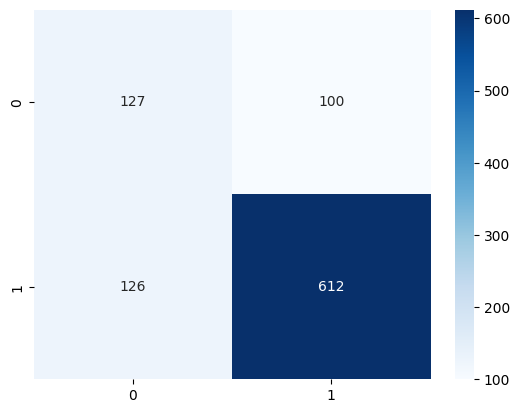

              precision    recall  f1-score   support

     Healthy       0.50      0.56      0.53       227
 Parkinson's       0.86      0.83      0.84       738

    accuracy                           0.77       965
   macro avg       0.68      0.69      0.69       965
weighted avg       0.78      0.77      0.77       965



In [327]:
# Confusion Matrix
y_pred = (model.predict([X_test_left, X_test_right]) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson's"]))

### Plot Training Accuracy & Loss Curves

In [328]:
 # Extract loss & accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

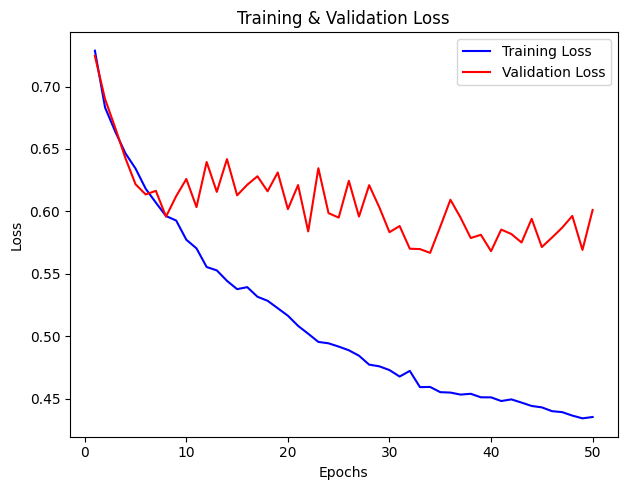

In [329]:
# Plot Loss Curve
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()